In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from tqdm import tqdm
from pathlib import Path
from scipy import stats

#### Use Latex text rendering for plots

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'], 'size' : 11})
rc('text', usetex=True)

In [4]:
folder = Path("data/")

In [62]:
scr_csvs = list(folder.glob("scr*.csv"))
# for the smoothened dataset we need to filter out the smoothened differences
smt_csvs = [folder for folder in folder.glob("smt*.csv") if "diff" not in folder.name]
smtdiff_csvs = list(folder.glob("smt_diff*.csv"))
ptd_csvs = list(folder.glob("ptd*.csv"))

In [63]:
scr_data = pd.concat(map(lambda x: pd.read_csv(x, index_col=0), scr_csvs))
smt_data = pd.concat(map(lambda x: pd.read_csv(x, index_col=0), smt_csvs))
smtdiff_data = pd.concat(map(lambda x: pd.read_csv(x, index_col=0), smtdiff_csvs))
ptd_data = pd.concat(map(lambda x: pd.read_csv(x, index_col=0), ptd_csvs))

In [64]:
scr_data.columns = scr_data.columns.str.replace('_','')
smt_data.columns = smt_data.columns.str.replace('_','')
smtdiff_data.columns = smtdiff_data.columns.str.replace('_','')
ptd_data.columns = ptd_data.columns.str.replace('_','')

### Scramnled Imagenette

To analyze the performance across patches, we need a column that indicates the ptch size

In [65]:
scr_data["patchsize"] = scr_data["file"].apply(lambda x: x.split("_")[2])

In [66]:
scr_data["patchsize"] = scr_data["patchsize"].replace("original", 224)
scr_data["patchsize"] = pd.to_numeric(scr_data["patchsize"]) 

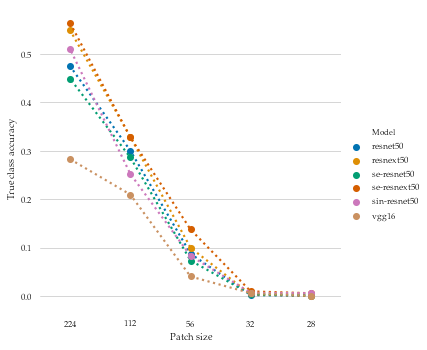

In [108]:
ax = sns.catplot(data=scr_data.groupby(["model", "patchsize"])[["trueacc"]].mean().reset_index(),
                 x="patchsize", y="trueacc", hue="model", kind="point", linestyles=":",
                 plot_kws={"line_kws":{"alpha":0.01}, "alpha":0.1, "lines.linewidth": 0.7})
ax.fig.axes[0].invert_xaxis()
ax.set(xlabel='Patch size', ylabel='True class accuracy')
ax._legend.set_title("Model")
sns.despine(bottom = True, left = True)

In [12]:
ax.savefig(folder / "scr_analysis.pdf")

In [176]:
scr_data[scr_data["model"] == "resnet50"].trueacc

0      0.012278
1      0.012278
2      0.006449
3      0.000007
4      0.000039
         ...   
385    0.001087
386    0.176746
387    0.006378
388    0.009428
389    0.997173
Name: trueacc, Length: 390, dtype: float64

#### Hypothesis 1
A scrambled image has a larger impact on the performance of a StyleNet, than on a standard ResNet.

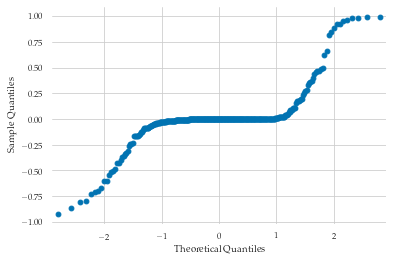

In [120]:
g = sm.qqplot(scr_data[scr_data["model"] == "resnet50"].trueacc - scr_data[scr_data["model"] == "sin-resnet50"].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_1.pdf")

In [119]:
stats.shapiro(scr_data[scr_data["model"] == "resnet50"].trueacc - scr_data[scr_data["model"] == "sin-resnet50"].trueacc,)

(0.6113136410713196, 1.072173866725124e-28)

In [77]:
stats.wilcoxon(scr_data[scr_data["model"] == "resnet50"].trueacc, scr_data[scr_data["model"] == "sin-resnet50"].trueacc, alternative="greater")

WilcoxonResult(statistic=31380.0, pvalue=0.9987641193194791)

Test if it applies to only the first stage

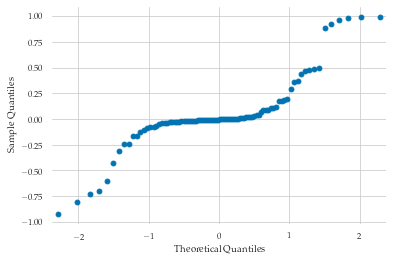

In [121]:
g = sm.qqplot(scr_data[(scr_data["model"] == "resnet50") & (scr_data["patchsize"] == 112)].trueacc - 
              scr_data[(scr_data["model"] == "sin-resnet50") & (scr_data["patchsize"] == 112)].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_1_1.pdf")

In [123]:
stats.shapiro(scr_data[(scr_data["model"] == "resnet50") & (scr_data["patchsize"] == 112)].trueacc - 
              scr_data[(scr_data["model"] == "sin-resnet50") & (scr_data["patchsize"] == 112)].trueacc)

(0.812435507774353, 2.4602562209707912e-09)

In [124]:
stats.wilcoxon(scr_data[(scr_data["model"] == "resnet50") & (scr_data["patchsize"] == 112)].trueacc - 
              scr_data[(scr_data["model"] == "sin-resnet50") & (scr_data["patchsize"] == 112)].trueacc, alternative="greater")

WilcoxonResult(statistic=2113.0, pvalue=0.3960621063685556)

### Smoothed Imagenette

In [131]:
smt_data["smtop"] = smt_data["file"].apply(lambda x: x.split("_")[2])
smt_data["smtop"] = smt_data["smtop"].replace("original", 0)
smt_data["smtop"] = pd.to_numeric(smt_data["smtop"]) 

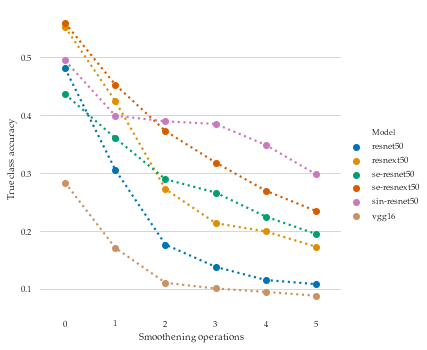

In [132]:
ax = sns.catplot(data=smt_data.groupby(["model", "smtop"])[["trueacc"]].mean().reset_index(),
           x="smtop", y="trueacc", hue="model", kind="point", linestyles=":")

ax.set(xlabel='Smoothening operations', ylabel='True class accuracy')
ax._legend.set_title("Model")
sns.despine(bottom = True, left = True)

In [15]:
ax.savefig(folder / "smt_analysis.pdf")

#### Hypothesis 3
A StyleNet should be less sensitive to texture removal than a standard ResNet.

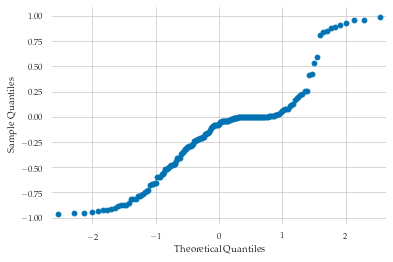

In [113]:
g = sm.qqplot(smt_data[smt_data["model"] == "resnet50"].trueacc - smt_data[smt_data["model"] == "sin-resnet50"].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_3.pdf")

In [116]:
stats.shapiro(smt_data[smt_data["model"] == "resnet50"].trueacc - smt_data[smt_data["model"] == "sin-resnet50"].trueacc)

(0.9237726330757141, 4.2902584596049564e-08)

In [81]:
stats.wilcoxon(smt_data[smt_data["model"] == "resnet50"].trueacc, smt_data[smt_data["model"] == "sin-resnet50"].trueacc, alternative="less")

WilcoxonResult(statistic=3882.0, pvalue=5.658147574460772e-10)

Test if it applies to only the first stage

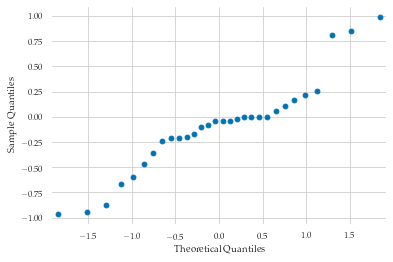

In [150]:
g = sm.qqplot(smt_data[(smt_data["model"] == "resnet50") & (smt_data["smtop"] == 1)].trueacc - 
              smt_data[(smt_data["model"] == "sin-resnet50") & (smt_data["smtop"] == 1)].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_3_0.pdf")

In [177]:
stats.shapiro(smt_data[(smt_data["model"] == "resnet50") & (smt_data["smtop"] == 1)].trueacc - 
              smt_data[(smt_data["model"] == "sin-resnet50") & (smt_data["smtop"] == 1)].trueacc)

(0.928175687789917, 0.04392863065004349)

In [179]:
stats.wilcoxon(smt_data[(smt_data["model"] == "resnet50") & (smt_data["smtop"] == 1)].trueacc -
              smt_data[(smt_data["model"] == "sin-resnet50") & (smt_data["smtop"] == 1)].trueacc, alternative="less")

WilcoxonResult(statistic=156.0, pvalue=0.05780409381199176)

In [178]:
stats.ttest_rel(smt_data[(smt_data["model"] == "resnet50") & (smt_data["smtop"] == 1)].trueacc,
              smt_data[(smt_data["model"] == "sin-resnet50") & (smt_data["smtop"] == 1)].trueacc)

Ttest_relResult(statistic=-1.1006509568240272, pvalue=0.2801010066657508)

#### Hypothesis 3.1
A SE-ResNet should perform better than a standard ResNet.

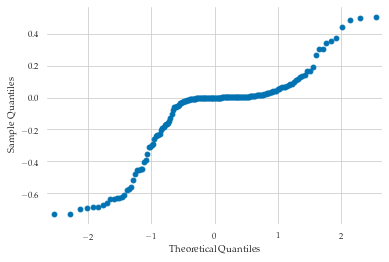

In [162]:
g = sm.qqplot(smt_data[smt_data["model"] == "resnet50"].trueacc - smt_data[smt_data["model"] == "se-resnet50"].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_3_1.pdf")

In [163]:
stats.shapiro(smt_data[smt_data["model"] == "resnet50"].trueacc - smt_data[smt_data["model"] == "se-resnet50"].trueacc)

(0.8182232975959778, 1.0414978883661885e-13)

In [164]:
stats.wilcoxon(smt_data[smt_data["model"] == "resnet50"].trueacc, smt_data[smt_data["model"] == "se-resnet50"].trueacc, alternative="less")

WilcoxonResult(statistic=6648.0, pvalue=0.01624028274512348)

Test if it applies to only the first stage

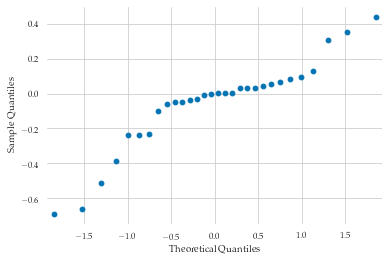

In [165]:
g = sm.qqplot(smt_data[(smt_data["model"] == "resnet50") & (smt_data["smtop"] == 1)].trueacc - 
              smt_data[(smt_data["model"] == "se-resnet50") & (smt_data["smtop"] == 1)].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_3_11.pdf")

In [168]:
stats.shapiro(smt_data[(smt_data["model"] == "resnet50") & (smt_data["smtop"] == 1)].trueacc - 
              smt_data[(smt_data["model"] == "se-resnet50") & (smt_data["smtop"] == 1)].trueacc)

(0.8952816724777222, 0.006451309192925692)

In [175]:
stats.wilcoxon(smt_data[(smt_data["model"] == "resnet50") & (smt_data["smtop"] == 1)].trueacc-
              smt_data[(smt_data["model"] == "se-resnet50") & (smt_data["smtop"] == 1)].trueacc, alternative="less")

WilcoxonResult(statistic=203.0, pvalue=0.2720031037920946)

#### Hypothesis 3.2
A SE-ResNeXt should perform better a StyleNet.

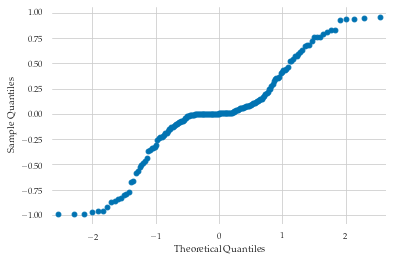

In [156]:
g = sm.qqplot(smt_data[smt_data["model"] == "sin-resnet50"].trueacc - smt_data[smt_data["model"] == "se-resnext50"].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_3.1.pdf")

In [157]:
stats.shapiro(smt_data[smt_data["model"] == "sin-resnet50"].trueacc - smt_data[smt_data["model"] == "se-resnext50"].trueacc)

(0.9277023673057556, 8.323478795091432e-08)

In [158]:
stats.wilcoxon(smt_data[smt_data["model"] == "sin-resnet50"].trueacc - smt_data[smt_data["model"] == "se-resnext50"].trueacc, alternative="less")

WilcoxonResult(statistic=9012.0, pvalue=0.8922344098940684)

Test if it applies to only the first stage

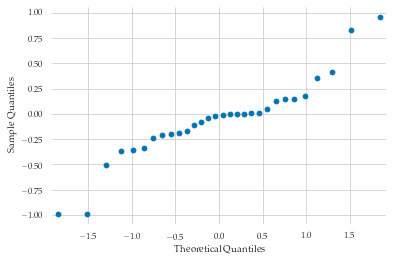

In [171]:
g = sm.qqplot(smt_data[(smt_data["model"] == "sin-resnet50") & (smt_data["smtop"] == 1)].trueacc - 
              smt_data[(smt_data["model"] == "se-resnext50") & (smt_data["smtop"] == 1)].trueacc,
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_3_11.pdf")

In [172]:
stats.shapiro(smt_data[(smt_data["model"] == "sin-resnet50") & (smt_data["smtop"] == 1)].trueacc - 
              smt_data[(smt_data["model"] == "se-resnext50") & (smt_data["smtop"] == 1)].trueacc)

(0.9193778038024902, 0.025843104347586632)

In [174]:
stats.ttest_rel(smt_data[(smt_data["model"] == "sin-resnet50") & (smt_data["smtop"] == 1)].trueacc, 
              smt_data[(smt_data["model"] == "se-resnext50") & (smt_data["smtop"] == 1)].trueacc)

Ttest_relResult(statistic=-0.7243511656460478, pvalue=0.47465389874445074)

#### Additional analysis unrelated to hypotheses

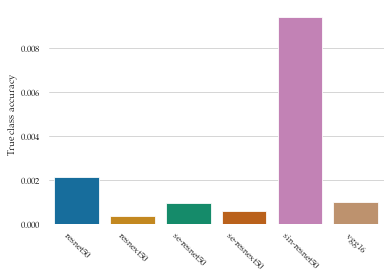

In [16]:
ax = sns.barplot(data=smtdiff_data.groupby(["model"])[["trueacc"]].mean().reset_index(),
          x="model", y="trueacc")

ax.set(xlabel="", ylabel='True class accuracy')
plt.xticks(rotation=-45)
sns.despine(bottom = True, left = True)

In [17]:
ax.figure.savefig(folder / "smtdiff_analysis.pdf", bbox_inches = "tight")

_____________

## Interaction analysis

Add `patchsize` and `patchnum` columns to dataframe

In [18]:
ptd_data["patchsize"] = ptd_data["file"].apply(lambda x: x.split("_")[2])
ptd_data["patchnum"] = ptd_data["file"].apply(lambda x: x.split("_")[3] if "original" not in x else x.split("_")[2])
#ptd_data["patchnum"] = pd.to_numeric(ptd_data["patchnum"]) 

Sort it with `file` and `patchnum`

In [19]:
ptd_data.sort_values(by=["file", "patchnum"], inplace=True)
ptd_data[:5]

,file,origfile,predacc,predclass,predlogit,predname,trueacc,trueclass,truelogit,truename,model,patchsize,patchnum
0,n01440764_1009_10_0,n01440764_1009,0.781319,0,11.351951,"tench, Tinca tinca",0.781319,0,11.351951,"tench, Tinca tinca",resnext50,10,0
0,n01440764_1009_10_0,n01440764_1009,0.940279,0,12.766439,"tench, Tinca tinca",0.940279,0,12.766439,"tench, Tinca tinca",resnet50,10,0
0,n01440764_1009_10_0,n01440764_1009,0.988548,0,14.997751,"tench, Tinca tinca",0.988548,0,14.997751,"tench, Tinca tinca",sin-resnet50,10,0
0,n01440764_1009_10_0,n01440764_1009,0.593204,0,8.561866,"tench, Tinca tinca",0.593204,0,8.561866,"tench, Tinca tinca",se-resnext50,10,0
0,n01440764_1009_10_0,n01440764_1009,0.271452,601,9.282571,"hoopskirt, crinoline",0.014379,0,6.344529,"tench, Tinca tinca",vgg16,10,0


### 1. Organize data

Create dataframe that only contains the `original` and therefore unmodified image

In [20]:
ptd_orig_only = ptd_data[ptd_data["file"].str.contains("original")]
ptd_orig_only[:5]

,file,origfile,predacc,predclass,predlogit,predname,trueacc,trueclass,truelogit,truename,model,patchsize,patchnum
201,n01440764_1009_original,n01440764_1009,0.780536,0,11.262298,"tench, Tinca tinca",0.780536,0,11.262298,"tench, Tinca tinca",resnext50,original,original
201,n01440764_1009_original,n01440764_1009,0.947202,0,12.853533,"tench, Tinca tinca",0.947202,0,12.853533,"tench, Tinca tinca",resnet50,original,original
201,n01440764_1009_original,n01440764_1009,0.989271,0,15.140967,"tench, Tinca tinca",0.989271,0,15.140967,"tench, Tinca tinca",sin-resnet50,original,original
201,n01440764_1009_original,n01440764_1009,0.669557,0,8.926115,"tench, Tinca tinca",0.669557,0,8.926115,"tench, Tinca tinca",se-resnext50,original,original
201,n01440764_1009_original,n01440764_1009,0.259290,601,9.497150,"hoopskirt, crinoline",0.016737,0,6.756806,"tench, Tinca tinca",vgg16,original,original


Create dataframe that does only contain patched images

In [21]:
ptd_wo_orig = pd.DataFrame(ptd_data[ptd_data["patchsize"]  != "original"])
ptd_wo_orig["patchnum"] = pd.to_numeric(ptd_wo_orig["patchnum"])
ptd_wo_orig["patchsize"] = pd.to_numeric(ptd_wo_orig["patchsize"]) 
ptd_wo_orig.reset_index(inplace=True, drop=True)
ptd_wo_orig[:5]

,file,origfile,predacc,predclass,predlogit,predname,trueacc,trueclass,truelogit,truename,model,patchsize,patchnum
0,n01440764_1009_10_0,n01440764_1009,0.781319,0,11.351951,"tench, Tinca tinca",0.781319,0,11.351951,"tench, Tinca tinca",resnext50,10,0
1,n01440764_1009_10_0,n01440764_1009,0.940279,0,12.766439,"tench, Tinca tinca",0.940279,0,12.766439,"tench, Tinca tinca",resnet50,10,0
2,n01440764_1009_10_0,n01440764_1009,0.988548,0,14.997751,"tench, Tinca tinca",0.988548,0,14.997751,"tench, Tinca tinca",sin-resnet50,10,0
3,n01440764_1009_10_0,n01440764_1009,0.593204,0,8.561866,"tench, Tinca tinca",0.593204,0,8.561866,"tench, Tinca tinca",se-resnext50,10,0
4,n01440764_1009_10_0,n01440764_1009,0.271452,601,9.282571,"hoopskirt, crinoline",0.014379,0,6.344529,"tench, Tinca tinca",vgg16,10,0


Get the `fully patchched` image names. These are in each class those with the highest patch number

In [22]:
fully_patched = []

for date, new_df in ptd_wo_orig.groupby(["model", "patchsize", "origfile"]):
    patched_file = new_df.loc[new_df["patchnum"].idxmax(), "file"]
    fully_patched.append(patched_file)

Create dataframe that neither contains `original` nor `fully patched` images

In [23]:
ptd_wo_orig_full = pd.DataFrame(ptd_wo_orig[ptd_wo_orig["file"].apply(lambda x: x not in fully_patched)])
ptd_wo_orig_full.reset_index(inplace=True, drop=True)
ptd_wo_orig_full[:5]

,file,origfile,predacc,predclass,predlogit,predname,trueacc,trueclass,truelogit,truename,model,patchsize,patchnum
0,n01440764_1009_10_0,n01440764_1009,0.781319,0,11.351951,"tench, Tinca tinca",0.781319,0,11.351951,"tench, Tinca tinca",resnext50,10,0
1,n01440764_1009_10_0,n01440764_1009,0.940279,0,12.766439,"tench, Tinca tinca",0.940279,0,12.766439,"tench, Tinca tinca",resnet50,10,0
2,n01440764_1009_10_0,n01440764_1009,0.988548,0,14.997751,"tench, Tinca tinca",0.988548,0,14.997751,"tench, Tinca tinca",sin-resnet50,10,0
3,n01440764_1009_10_0,n01440764_1009,0.593204,0,8.561866,"tench, Tinca tinca",0.593204,0,8.561866,"tench, Tinca tinca",se-resnext50,10,0
4,n01440764_1009_10_0,n01440764_1009,0.271452,601,9.282571,"hoopskirt, crinoline",0.014379,0,6.344529,"tench, Tinca tinca",vgg16,10,0


Create dataframe that only contains `fully patched` images

In [24]:
ptd_allpatched_only = pd.DataFrame(ptd_wo_orig[ptd_wo_orig["file"].apply(lambda x: x in fully_patched)])
ptd_allpatched_only.reset_index(inplace=True, drop=True)
ptd_allpatched_only[:5]

,file,origfile,predacc,predclass,predlogit,predname,trueacc,trueclass,truelogit,truename,model,patchsize,patchnum
0,n01440764_1009_10_121,n01440764_1009,0.473212,794,11.203139,shower curtain,3.869501e-06,0,-0.511033,"tench, Tinca tinca",resnext50,10,121
1,n01440764_1009_10_121,n01440764_1009,0.267507,918,10.623002,"crossword puzzle, crossword",3.764917e-07,0,-2.850759,"tench, Tinca tinca",resnet50,10,121
2,n01440764_1009_10_121,n01440764_1009,0.085010,600,6.097659,"hook, claw",5.896164e-06,0,-3.478559,"tench, Tinca tinca",sin-resnet50,10,121
3,n01440764_1009_10_121,n01440764_1009,0.365066,794,6.912612,shower curtain,3.476395e-04,0,-0.044055,"tench, Tinca tinca",se-resnext50,10,121
4,n01440764_1009_10_121,n01440764_1009,0.318014,640,8.476188,manhole cover,2.381013e-05,0,-1.023552,"tench, Tinca tinca",vgg16,10,121


### 2. Calculate differences in logits

Subtract the `patched` `truelogit` from the `orignal` `truelogit`

In [32]:
for index, row in ptd_wo_orig_full.iterrows():
    temp_file = row["origfile"]
    temp_model = row["model"]
    # get orignal image's logit
    orig_logit = ptd_orig_only.query(f"origfile == '{temp_file}' & model == '{temp_model}'")["truelogit"]
    # subtract orignal image logit and patched image logit
    ptd_wo_orig_full.at[index, "logdifforig"] = float(orig_logit) - row["truelogit"]

In [33]:
ptd_wo_orig_full.logdifforig.mean()

0.22340283656433085

Subtract the `all patched` `truelogit` from the `orignal` `truelogit`

In [34]:
for index, row in ptd_allpatched_only.iterrows():
    temp_file = row["origfile"]
    temp_model = row["model"]
    # get orignal image's logit
    orig_logit = ptd_orig_only.query(f"origfile == '{temp_file}' & model == '{temp_model}'")["truelogit"]
    # subtract orignal image logit and patched image logit
    ptd_allpatched_only.at[index, "logdifforig"] = float(orig_logit) - row["truelogit"]

In [35]:
ptd_allpatched_only.logdifforig.mean()

7.553170168152937

Get the sum of the calculated differences over `model` `patchsize` `origfile` for the `patched` images

In [36]:
diff_wo_orig_full = ptd_wo_orig_full.groupby(["model", "patchsize", "origfile"])[["origfile", "logdifforig"]].sum()
diff_wo_orig_full.reset_index(inplace=True)
diff_wo_orig_full[:5]

,model,patchsize,origfile,logdifforig
0,resnet50,10,n01440764_1009,51.083311
1,resnet50,10,n01440764_1091,79.203140
2,resnet50,10,n01440764_11170,0.993132
3,resnet50,10,n02102040_1487,42.668682
4,resnet50,10,n02102040_565,27.713459


Get the sum of the calculated differences over `model` `patchsize` `origfile` for the `all patched` images

In [37]:
diff_allpatched_only = ptd_allpatched_only.sort_values(["model", "patchsize"])[["model", "patchsize", "origfile", "logdifforig"]]
diff_allpatched_only[:5]

,model,patchsize,origfile,logdifforig
1,resnet50,10,n01440764_1009,15.704291
43,resnet50,10,n01440764_1091,14.587053
85,resnet50,10,n01440764_11170,15.490631
127,resnet50,10,n02102040_1487,6.230238
169,resnet50,10,n02102040_565,12.593338


### 3. Caclulate correlation

Create a dataframe that contains both the `patched` and the `all patched` differences

In [38]:
diff = pd.merge(diff_wo_orig_full, diff_allpatched_only, how="outer", on=["model", "patchsize", "origfile"], suffixes=('_wo_orig_full', '_allpatched_only'))
diff[:5]

,model,patchsize,origfile,logdifforig_wo_orig_full,logdifforig_allpatched_only
0,resnet50,10,n01440764_1009,51.083311,15.704291
1,resnet50,10,n01440764_1091,79.203140,14.587053
2,resnet50,10,n01440764_11170,0.993132,15.490631
3,resnet50,10,n02102040_1487,42.668682,6.230238
4,resnet50,10,n02102040_565,27.713459,12.593338


Calculate Person correlation of both differences 

In [39]:
models = diff.model.unique()
patchsizes = diff.patchsize.unique()

In [40]:
corrs = []

for model in models:
    for patchsize in patchsizes:
        diff_subset = diff[(diff["model"] == model) & (diff["patchsize"] == patchsize)]
        corr = diff_subset["logdifforig_wo_orig_full"].corr(diff_subset["logdifforig_allpatched_only"])
        corrs.append([model, patchsize, corr])

In [41]:
diff_corr = pd.DataFrame(corrs, columns=["model", "patchsize", "correlation"])
diff_corr[:5]

,model,patchsize,correlation
0,resnet50,10,0.291556
1,resnet50,20,0.463427
2,resnet50,30,0.657217
3,resnet50,40,0.779644
4,resnet50,50,0.926443


### 4. Plot the differences

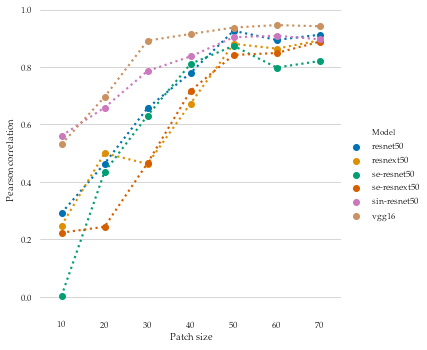

In [42]:
ax = sns.catplot(data=diff_corr,
           x="patchsize", y="correlation", hue="model", kind="point", linestyles=":")

ax.set(xlabel='Patch size', ylabel='Pearson correlation')
ax._legend.set_title("Model")
sns.despine(bottom = True, left = True)

Due to the small amount of patches, a test is not really interesting or reasonable under the circumstances

In [82]:
stats.wilcoxon(diff_corr[diff_corr["model"] == "resnet50"].correlation, diff_corr[diff_corr["model"] == "sin-resnet50"].correlation, alternative="less")

/home/malte/anaconda3/envs/kerasCPU/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=5.0, pvalue=0.06409508717255392)

In [43]:
ax.savefig(folder / "ptdcorr_analysis.pdf")

In [45]:
diff_res = diff[diff["model"] == "resnet50"]
diff_res.columns = diff_res.columns.str.replace("_", "")

/home/malte/anaconda3/envs/kerasCPU/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


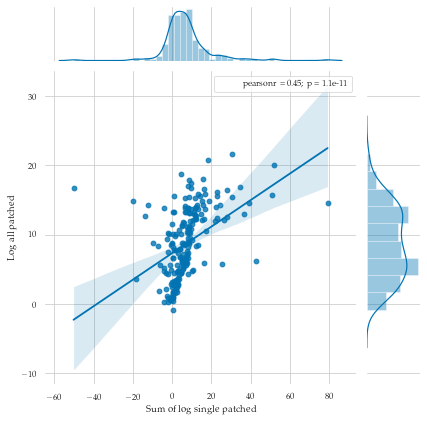

In [94]:
ax = sns.jointplot(data=diff_res, x="logdifforigwoorigfull", y="logdifforigallpatchedonly",
                   kind='reg', color=sns.color_palette("colorblind")[0])
ax.set_axis_labels(xlabel='Sum of log single patched', ylabel='Log all patched')
ax.annotate(stats.pearsonr)
sns.despine(bottom = True, left = True)

In [95]:
ax.savefig(folder / "res_corr.pdf")

In [86]:
diff_sin = diff[diff["model"] == "sin-resnet50"]
diff_sin.columns = diff_sin.columns.str.replace("_", "")

/home/malte/anaconda3/envs/kerasCPU/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


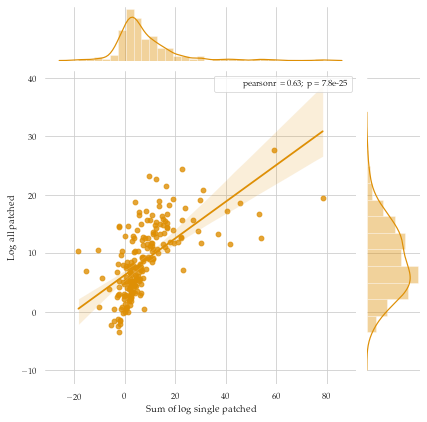

In [96]:
ax = sns.jointplot(data=diff_sin, x="logdifforigwoorigfull", y="logdifforigallpatchedonly",
                   kind='reg', color=sns.color_palette("colorblind")[1])
ax.set_axis_labels(xlabel='Sum of log single patched', ylabel='Log all patched')
ax.annotate(stats.pearsonr)
sns.despine(bottom = True, left = True)

In [97]:
ax.savefig(folder / "sin_corr.pdf")

In [89]:
diff_sern = diff[diff["model"] == "se-resnext50"]
diff_sern.columns = diff_sern.columns.str.replace("_", "")

/home/malte/anaconda3/envs/kerasCPU/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


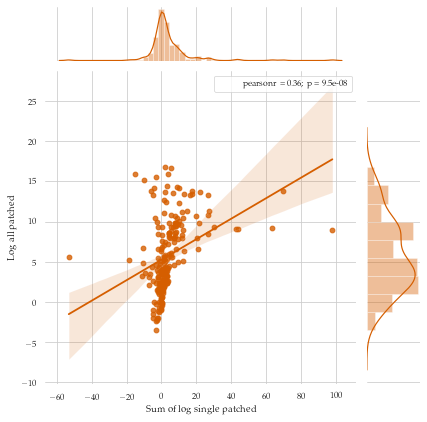

In [98]:
ax = sns.jointplot(data=diff_sern, x="logdifforigwoorigfull", y="logdifforigallpatchedonly",
                   kind='reg', color=sns.color_palette("colorblind")[3])
ax.set_axis_labels(xlabel='Sum of log single patched', ylabel='Log all patched')
ax.annotate(stats.pearsonr)
sns.despine(bottom = True, left = True)

In [99]:
ax.savefig(folder / "seresn_corr.pdf")

In [54]:
diff_vgg16 = diff[diff["model"] == "vgg16"]
diff_vgg16.columns = diff_sern.columns.str.replace("_", "")

/home/malte/anaconda3/envs/kerasCPU/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


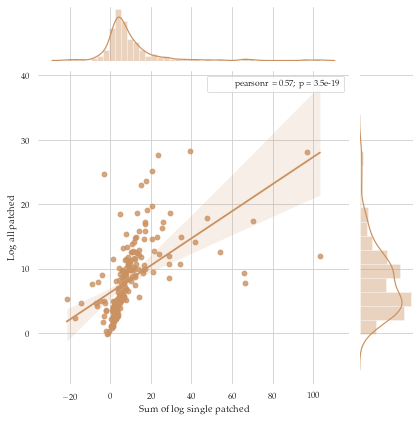

In [100]:
ax = sns.jointplot(data=diff_vgg16, x="logdifforigwoorigfull", y="logdifforigallpatchedonly",
                   kind='reg', color=sns.color_palette("colorblind")[5])
ax.set_axis_labels(xlabel='Sum of log single patched', ylabel='Log all patched')
ax.annotate(stats.pearsonr)
sns.despine(bottom = True, left = True)

In [101]:
ax.savefig(folder / "svgg_corr.pdf")

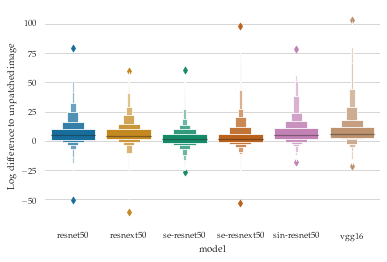

In [57]:
ax = sns.boxenplot(data=diff, x="model", y ="logdifforig_wo_orig_full")

ax.set(ylabel='Log difference to unpatched image')
sns.despine(bottom = True, left = True)